# Objective

* go through processing routine
* Do we have the relvant calibration files
    * What instruments are involved?
    * 1625 filterfunction for relevant instruments?

# Strategy

Apply Lab calibration
* ~~There seems to be an error in the caluculation of the direct horizontal and normal in those products for splash (not shown in the publicated data).~~
* This part should actually be somewhat hard coded in a script somewhere in SURFRAD package!
* Set it up so it prcesses all new data that is comming in
* imitate what has been done in /home/grad/htelg/projects/ASR/splash/apply_calibrations/calibrate_v0.2.ipynb
* We will need MFRSR only
* use most recent Charls calibrations

Based on the files created above come up with a code to get AOD based on Lab cals
* choose single number for top fo the atmosphere spectral irradiance
* how is the earth-sun distance implemented now, deviation from mean?


# Calibrate files

In [3]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as atmsrf

# Make AOD

In [4]:
import atmPy.radiation.retrievals.spectral_irradiance as atmspec

In [5]:
fn = '/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.2021/v0.2/cbc_specflux_20230528.nc'
dssf = xr.open_dataset(fn)
fn = '/nfs/grad/campaigns/splash/data_products/spectral_surface_albedo/v1.0/cbc/cbc.spectral_surface_albedo.20230528.nc'
dsal = xr.open_dataset(fn)

In [6]:
atmspec.CombinedGlobalDiffuseDirect

atmPy.radiation.retrievals.spectral_irradiance.CombinedGlobalDiffuseDirect

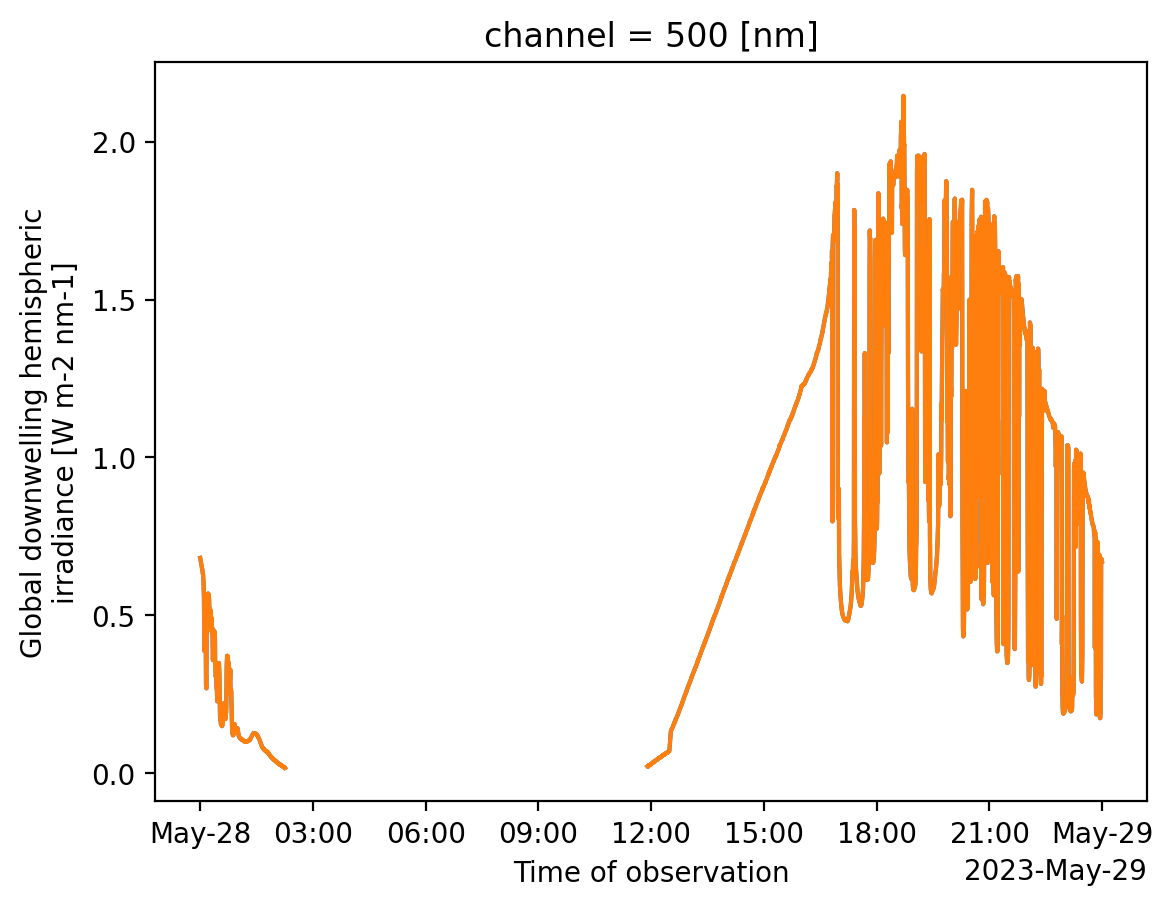

In [7]:
dssf.global_horizontal.sel(channel=550, method='nearest').plot()
dsal.downwelling_hemispheric_irradiance.sel(channel=550, method='nearest').plot()

## Use the top of the atmosphere solar constant

Once you correct for the variation in the Earth–Sun distance (which causes the ~±3.5% annual cycle in irradiance), the solar irradiance at the top of the atmosphere (the “solar constant”) is essentially constant:  

- **Mean value**: ~1361 W m⁻² (according to TIM/SORCE and other modern radiometers).  
- **Short-term variability**:  
  - On the timescale of minutes to hours: very small (≲0.01%), except during solar flares.  
  - Over the 11-year solar cycle: about ±0.05% to ±0.1% (~1–1.5 W m⁻²).  
- **Longer term trends**: No statistically significant secular trend has been measured over the past 40+ years of satellite monitoring; variations remain within ~1 W m⁻².  

👉 So, once Earth–Sun distance is accounted for, **the top-of-atmosphere solar irradiance is stable to better than 0.1%**, with only the solar cycle and transient events (like flares) causing small changes.  

Do you want me to also show how this translates into changes in absorbed solar energy by Earth (W m⁻² at the surface averaged globally)?


In [ ]:
def read_splash_met_data(site):    
    year = pd.to_datetime(ro.dataset.datetime.values[0]).year
    p2f_met = f'/home/grad/sedlar/data/splash/surfrad/all_variables/{site}_concat_surfrad_all_variables{year}.nc'
    dsmet = xr.open_dataset(p2f_met)
    dsmet['time'] = pd.to_datetime(dsmet['time'], unit='d')
    pt_interp = dsmet[['temp','pressure']].interp(time = ro.dataset.datetime)
    return pt_interp


In [15]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as atmsrf
import atmPy.radiation.retrievals.spectral_irradiance as atmspec

In [ ]:

fn = '/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.2021/v0.2/cbc_specflux_20220625.nc'
# fn = '/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.sbs2021/v0.2/cbc_specflux_20230528.nc'
dssf = xr.open_dataset(fn)
dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)

In [422]:
reload(atmspec)
reload(atmsrf)

<module 'atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad' from '/home/grad/htelg/prog_dev/atm-py/atmPy/data_archives/NOAA_ESRL_GMD_GRAD/surfrad/surfrad.py'>

In [521]:
fld = pl.Path('/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/ckp/cal.fact/v0.2/')
fns = list(fld.glob('*'))
fns.sort()

In [522]:
i = 224 # 102: claer sky
# i += 1
fn = fns[i]
dssf = xr.open_dataset(fn)
scale = 1 + 0.3
dssf['direct_normal'] *= scale
dssf = dssf.drop_sel(channel= 1625) # for now as it is more complicated
# dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)
# ro.plot_overview(show_alltime=False)
i

ro.direct_normal_irradiation.settings_calibration = 'toa_radiation'

ro.direct_normal_irradiation.transmission
# ro.direct_normal_irradiation._transmission *= scale

# ro.direct_normal_irradiation.transmission.plot.line(x = 'datetime')
# f,a = plt.subplots()
# ro.direct_normal_irradiation.od_total.plot.line(x='datetime', ax=a)
# a.set_ylim(0,1)

ro.direct_normal_irradiation.settings_metdata = lambda : read_splash_met_data('ckp')
# ro.direct_normal_irradiation.od_rayleigh.plot.line(x='datetime')
ro.direct_normal_irradiation.settings_ozone = 300 # DU
f,a = plt.subplots()
ro.direct_normal_irradiation.aod.plot.line(x='datetime', ax=a)
a.set_ylim(-0.1,0.4)

IndexError: list index out of range

In [528]:
fld = pl.Path('/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.2021/v0.2/')
fns = list(fld.glob('*'))
fns.sort()

/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/solar.py:125: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/retrievals/spectral_irradiance.py:1116: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds['co2'] = xr.DataArray(np.zeros(tuple(self.raw_data.dims[d] for d in ['datetime', 'channel'])),


(0.0, 0.4)

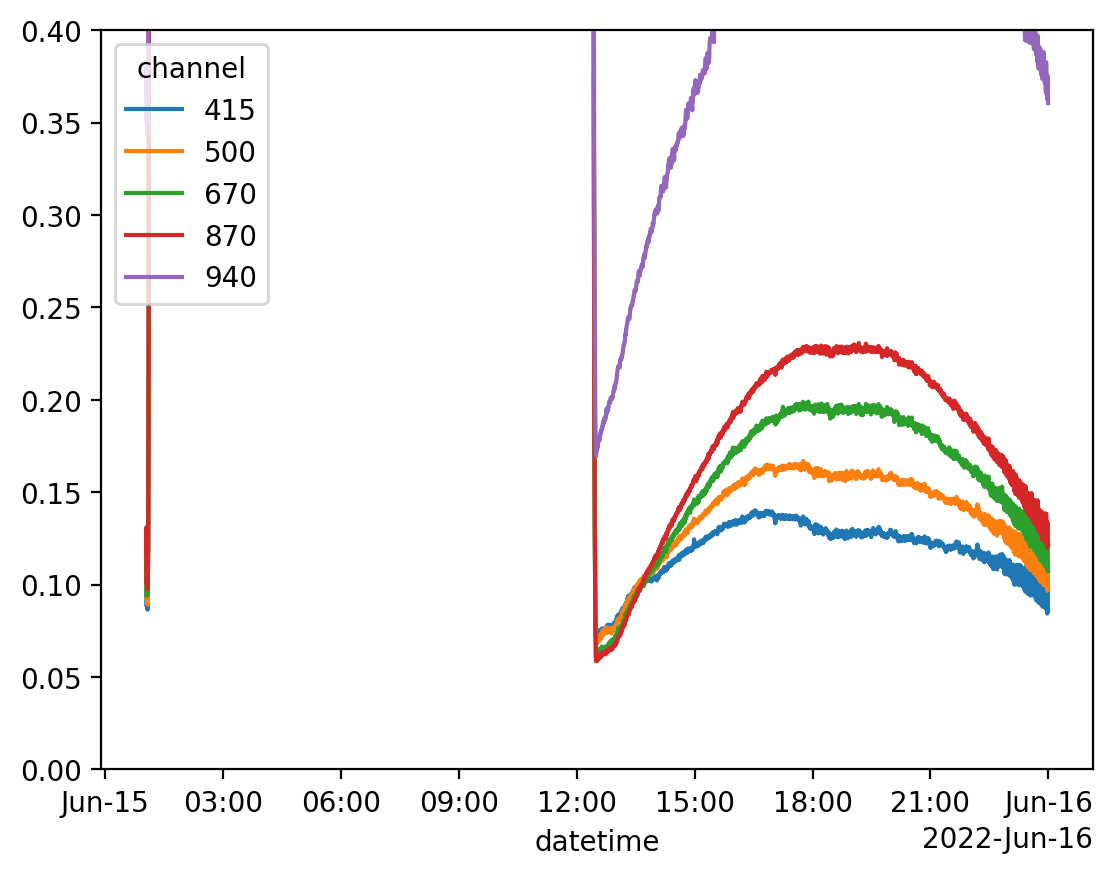

In [529]:
i = 242 # 102: claer sky, but winter
          # 242: clear sky, but summer
# i += 1 #
fn = fns[i]
dssf = xr.open_dataset(fn)
scale = 1 + 0.1
# dssf['direct_normal'] *= scale
dssf = dssf.drop_sel(channel= 1625) # for now as it is more complicated
# dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)
# ro.plot_overview(show_alltime=False)
i


ro.direct_normal_irradiation.settings_calibration = 'toa_radiation'

ro.direct_normal_irradiation.transmission
# ro.direct_normal_irradiation._transmission *= scale

# ro.direct_normal_irradiation.transmission.plot.line(x = 'datetime')
# f,a = plt.subplots()
# ro.direct_normal_irradiation.od_total.plot.line(x='datetime', ax=a)
# a.set_ylim(0,1)

ro.direct_normal_irradiation.settings_metdata = lambda : read_splash_met_data('cbc')
# ro.direct_normal_irradiation.od_rayleigh.plot.line(x='datetime')
ro.direct_normal_irradiation.settings_ozone = 300 # DU
f,a = plt.subplots()
ro.direct_normal_irradiation.aod.plot.line(x='datetime', ax=a)
a.set_ylim(0,0.4)

In [ ]:
fld = pl.Path('/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.fact/v0.2/')
fns = list(fld.glob('*'))
fns.sort()

/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/solar.py:125: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/retrievals/spectral_irradiance.py:1116: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds['co2'] = xr.DataArray(np.zeros(tuple(self.raw_data.dims[d] for d in ['datetime', 'channel'])),


(0.0, 0.4)

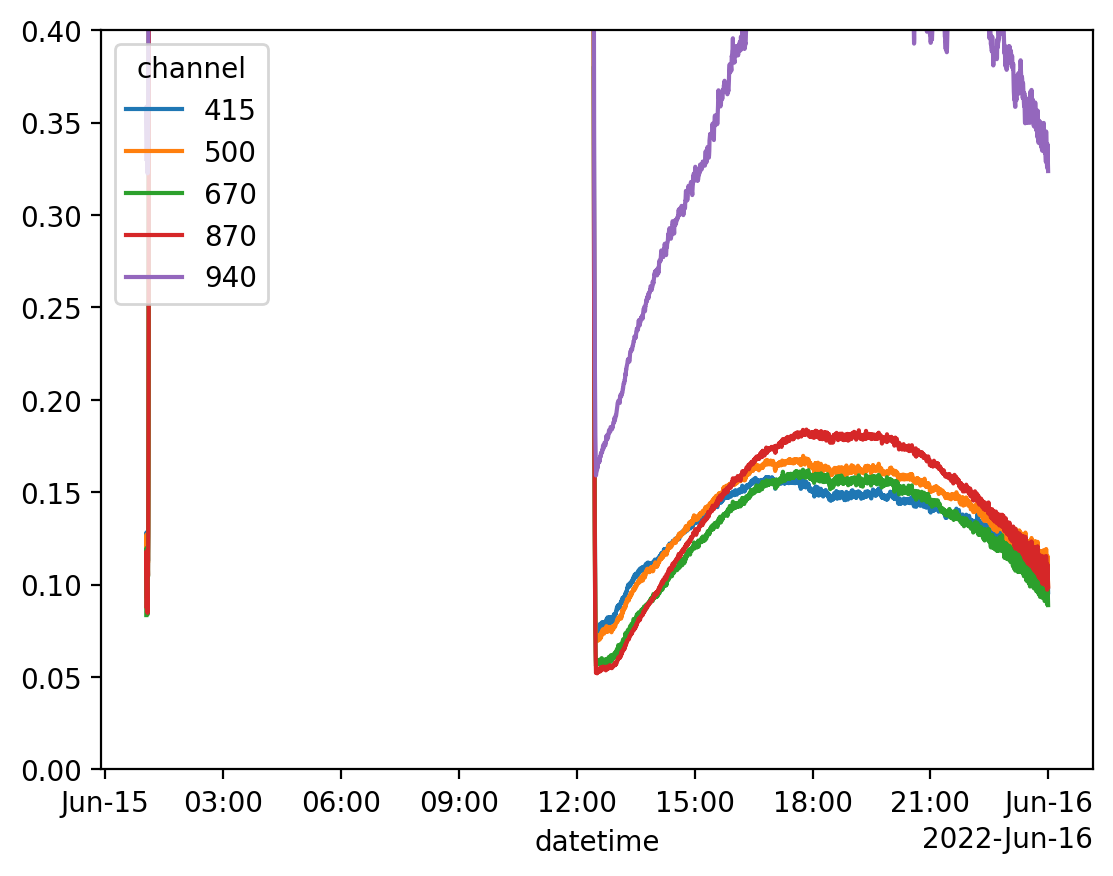

In [ ]:
i = 242 # 102: claer sky, but winter
          # 242: clear sky, but summer
# i += 1 #
fn = fns[i]
dssf = xr.open_dataset(fn)
scale = 1 + 0.1
# dssf['direct_normal'] *= scale
dssf = dssf.drop_sel(channel= 1625) # for now as it is more complicated
# dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)
# ro.plot_overview(show_alltime=False)
i


ro.direct_normal_irradiation.settings_calibration = 'toa_radiation'

ro.direct_normal_irradiation.transmission
# ro.direct_normal_irradiation._transmission *= scale

# ro.direct_normal_irradiation.transmission.plot.line(x = 'datetime')
# f,a = plt.subplots()
# ro.direct_normal_irradiation.od_total.plot.line(x='datetime', ax=a)
# a.set_ylim(0,1)

ro.direct_normal_irradiation.settings_metdata = lambda : read_splash_met_data('cbc')
# ro.direct_normal_irradiation.od_rayleigh.plot.line(x='datetime')
ro.direct_normal_irradiation.settings_ozone = 300 # DU
f,a = plt.subplots()
ro.direct_normal_irradiation.aod.plot.line(x='datetime', ax=a)
a.set_ylim(0,0.4)

In [434]:
ro.diffuse_horizontal_irradiation.tp

AttributeError: 'DiffuseHorizontalIrradiation' object has no attribute 'tp'

# Apply cloud screening

In [ ]:
atmsrf.open_path('/nfs/grad/Inst/')